In [ ]:
%pip install numpy
%pip install "dask[complete]"
%pip install "dask[distributed]"

In [3]:
import numpy as np
from threading import Thread
from multiprocessing import cpu_count
from time import time
from dask import delayed

import matplotlib.pyplot as plt 

In [4]:
MAX_UNITS = cpu_count()
MAX_X = 1024
MAX_Y = 1024

vector = np.int32( np.random.choice([1,0], MAX_X * MAX_Y, p = [0.50, 0.50]) )
vector_out = np.empty(MAX_X * MAX_Y, dtype = np.int32)

In [5]:
# Funciones auxiliares usadas para estimar los vecinos de una celda y
# garantizar que los valores del borde no se vayan a sobrepasar
#

def posx(x, max_x = MAX_X):
  return (x + max_x) % max_x

def posy(y, max_y = MAX_Y):
  return (y + max_y) % max_y

def indice(x,y, max_y = MAX_Y):
  return posx(x) * max_y + posy(y)

In [6]:
# Esta funcion se encarga de contar los 8 vecinos de una celda cuales están
# vivos (valor a '1') o cuantos están muertos (valor a '0')
#
#                 |                |
#  (X - 1, Y - 1) | (  X  , Y - 1) | (X + 1, Y - 1)
#                 |                |
# --------------------------------------------------
#                 |                |
#  (X - 1,   Y  ) | (  X  ,   Y  ) | (X + 1,   Y  )
#                 |                |
# --------------------------------------------------
#                 |                |
#  (X - 1, Y + 1) | (  X  , Y + 1) | (X + 1, Y + 1)
#

def vecinos(x,y,vector):
  return vector[ indice(x - 1, y - 1) ] + vector[ indice(x - 1, y) ] + vector[ indice(x - 1, y + 1) ] \
  + vector[ indice(x, y - 1) ] + vector[ indice(x, y + 1) ] \
  + vector[ indice(x + 1, y - 1) ] + vector[ indice(x + 1, y) ] + vector[ indice(x + 1, y + 1) ]

In [7]:
# Esta función se encarga de recorrer toda las celdas y estimar cuales de ellas 
# vivirán y cuales no 
#
def conway(low_limit = 0, high_limit = MAX_X):
    for i in range(low_limit,high_limit):
        for j in range(0,MAX_Y):
            n = vecinos(i,j, vector)
            valor = 0
            if vector[ indice(i,j) ] == 1 and (n == 2 or n == 3):
                valor = 1
            elif vector[ indice(i,j) ] == 0 and n == 3:
                valor = 1
            vector_out[ indice(i,j) ] = valor
    return 1

C:\Python311\Lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 56219 instead
  warnings.warn(


[0 0 0 ... 1 0 0]
[0 1 1 ... 0 0 0]
El tiempo que tomó calcular 2.5392038822174072


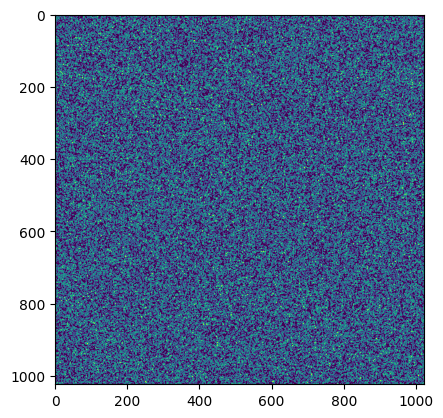

In [14]:
from dask.distributed import Client
client = Client()

print(vector)
# Variables usadas para hacer la partición de las filas que procesara cada
# nodo de procesamiento en el grafo generado por dask
stride = np.int32(MAX_X / MAX_UNITS)
count = np.int32(0)
nodes = [] # arreglo que almacenará aquellos nodos que se ejecutan
for t in range(MAX_UNITS):
    node = delayed(conway)(count, count + stride)
    nodes.append(node)
    count = count + stride

t1 = time()
results = delayed(sum)(nodes).compute()
t2 = time()
print(vector_out)
print(f"El tiempo que tomó calcular {t2 - t1}")
fig = plt.figure()
plt.imshow(vector_out.reshape(MAX_X,MAX_Y))
plt.show()  